In [1]:
from joblib import Parallel, delayed
from tqdm import tqdm

import numpy as np
import polars as pl
from lrv_test import LRV


from data_generation.arma import generate_arma_sample

In [2]:
# for the LRV test, we will always use the following test functions
f = lambda x: (x - 1) ** 2

# we will always evaluate the test against these values of N and M
N_range = np.linspace(1000, 8000, 8)
M_range = np.linspace(10, 80, 8)

c = 1 / 2
L_range = np.power(N_range, 0.25).astype(int)

# always repeat an experiment 1000 times
n_repeats = 1000

# threshold to detect
level = 0.1

# generate real gaussian data
is_complex_gaussian = True

# path to the stored experiment results for easy reloading
data_filepath_format = (
    "/Users/alexisrosuel/lrv-test/{experiment_type}/{experiment_id}.pickle"
)

In [3]:
def run(
    N,
    M,
    B,
    L,
    time_ar,
    time_ma,
    is_complex_gaussian,
    alpha,
):
    y = generate_arma_sample(
        N,
        M,
        time_ar,
        time_ma,
        is_complex_gaussian,
    )

    # frequencies to evaluate, exclude -0.5 and 0 as they
    # have not well behaved: big estimation error at these point
    # for spectral density
    freqs = np.arange(-0.4, 0.6, (B / N) * 1.1)

    lrv_result = LRV(
        y,
        B,
        f,
        freqs,
        L,
    )
    return {
        "N": N,
        "M": M,
        "B": B,
        "L": L,
        "time_ar": time_ar,
        "time_ma": time_ma,
        "is_complex_gaussian": is_complex_gaussian,
        "t_stats_0": lrv_result.t_stats_0,
        "t_stat_1": lrv_result.t_stat_1,
        "t_stat_2": lrv_result.t_stat_2,
        "t_stat_3": lrv_result.t_stat_3,
        "t_stat_4": lrv_result.t_stat_4,
        "p_values_0": lrv_result.p_values_0,
        "p_value_1": lrv_result.p_value_1,
        "p_value_2": lrv_result.p_value_2,
        "p_value_3": lrv_result.p_value_3,
        "p_value_4": lrv_result.p_value_4,
        "v_n": lrv_result.v_n,
        "alpha": alpha,
    }

In [4]:
time_ar, time_ma = 0.2, 0.2
c = 1 / 2
alpha_range = np.linspace(1 / 2, 4 / 5, 10)
N = 10_000

tasks = []
for alpha in alpha_range:
    M = N**alpha
    B = int(M / c) + 1
    if B % 2 == 0:
        B -= 1
    if B >= N:
        continue
    L = int(N**0.25)

    task = {
        "N": int(N),
        "M": int(M),
        "B": int(B),
        "L": int(L),
        "time_ar": time_ar,
        "time_ma": time_ma,
        "is_complex_gaussian": is_complex_gaussian,
        "alpha": alpha,
    }

    tasks.append(task)

# shuffle the tasks to distribute the load over time
np.random.shuffle(tasks)
results = Parallel(n_jobs=2)(delayed(run)(**task) for task in tqdm(tasks))

# df = load_batch(f"arma_no_dependence_{c}").drop(['t_stats_0', 'p_values_0'])
# positive_column_name = f"positive - {level:.0%}"

 80%|████████  | 8/10 [00:08<00:02,  1.16s/it]/Users/alexisrosuel/micromamba/envs/lrv312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


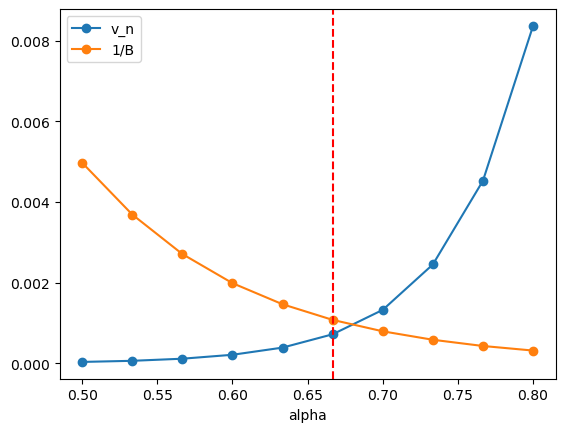

In [19]:
df = (
    pl.DataFrame(results)
    .drop(["t_stats_0", "p_values_0"])
    .select([(1 / pl.col("B")).alias("1/B"), "alpha", "v_n"])
    .sort("alpha")
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(df["alpha"], df["v_n"], marker="o", label="v_n")
ax.plot(df["alpha"], df["1/B"], marker="o", label="1/B")

# add a vertical line at 2/3
ax.axvline(x=2 / 3, color="r", linestyle="--")
ax.legend()

# set alpha as x axis
ax.set_xlabel("alpha")

# save fig
fig.savefig("v_n_vs_1_over_B.png")

In [ ]:
df.with_columns(
    (pl.col("p_value_1") < level).alias(positive_column_name).cast(pl.Float64)
).group_by(["N", "M", "time_ar", "time_ma"]).mean().to_pandas().pivot(
    index="N", columns=["M"], values=positive_column_name
)

M,10,20,30,40,50,60,70,80
N,,,,,,,,
1000,0.080,0.112,0.081,0.108,0.135,0.117,0.118,0.141
2000,0.063,0.097,0.084,0.106,0.105,0.096,0.089,0.103
3000,0.070,0.091,0.069,0.104,0.097,0.098,0.102,0.107
4000,0.072,0.094,0.080,0.096,0.103,0.108,0.099,0.103
5000,0.075,0.070,0.096,0.103,0.109,0.097,0.099,0.097
6000,0.068,0.092,0.079,0.112,0.098,0.102,0.107,0.075
7000,0.056,0.081,0.063,0.086,0.093,0.082,0.108,0.087
8000,0.070,0.102,0.102,0.100,0.097,0.110,0.097,0.083
